<a href="https://colab.research.google.com/github/why-arong/fake-voice-detection/blob/mel-resnet/ssl_unlabeled_mel_resnet_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prepare data

In [1]:
!wget 'https://drive.usercontent.google.com/download?id=1HLBDBTnrLvVdqXxMQTDJyTUf5ryBqcxD&export=download&authuser=1&confirm=t' -O open.zip

--2024-07-14 20:13:03--  https://drive.usercontent.google.com/download?id=1HLBDBTnrLvVdqXxMQTDJyTUf5ryBqcxD&export=download&authuser=1&confirm=t
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.250.145.132, 2a00:1450:4013:c14::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|142.250.145.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3313752771 (3.1G) [application/octet-stream]
Saving to: ‘open.zip’

open.zip            100%[===================>]   3.09G  64.9MB/s    in 74s     

2024-07-14 20:14:19 (42.6 MB/s) - ‘open.zip’ saved [3313752771/3313752771]



In [2]:
!unzip -q open.zip

# Import libraries and setting

In [56]:
import os
import random
import math

import numpy as np
import pandas as pd

from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchaudio
import torchaudio.transforms as T

from torchsummary import summary

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device

device(type='cuda')

In [68]:
SR = 16000
SEED = 1
BATCH = 32
EPOCH = 10
LR = 1e-4

In [69]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(SEED)

# Define dataset and augmetation pipeline

In [70]:
def convert_to_fixed_length(audio, fixed_len):
    _, length = audio.size()

    if length < fixed_len:
        to_pad = fixed_len - length
        left_pad = torch.randint(0, to_pad + 1, (1,)).item()
        right_pad = to_pad - left_pad
        audio = torch.nn.functional.pad(audio, (left_pad, right_pad), mode='constant', value=0)
    else:
        start = torch.randint(0, length - fixed_len + 1, (1,)).item()
        audio = audio[:, start:start + fixed_len]

    return audio


class AudioDataset(Dataset):
    def __init__(self, data_paths, labels, unlabeled_paths, fixed_len=64000):
        self.data_paths = data_paths
        self.labels = labels
        self.unlabeled_paths = unlabeled_paths
        self.fixed_len = fixed_len

        self.data_length = len(data_paths)
        self.unlabeled_length = len(unlabeled_paths)
        self.resample = T.Resample(32000, SR)

    def __len__(self):
        return self.data_length

    def __getitem__(self, idx):
        rand_val = random.random()

        if rand_val <= 0.15:
            wave = torch.zeros(1, self.fixed_len)
            merged_label = (0, 0)

        elif rand_val <= 0.3:
            path, label = self.data_paths[idx], self.labels[idx]
            wave, _ = torchaudio.load(path)
            wave = self.resample(wave)
            wave = convert_to_fixed_length(wave, self.fixed_len)
            merged_label = (0, 1) if label else (1, 0)

        elif rand_val <= 0.6:
            rand_idx = np.random.randint(0, self.data_length)
            path1, label1 = self.data_paths[idx], self.labels[idx]
            path2, label2 = self.data_paths[rand_idx], self.labels[rand_idx]

            wave1, _ = torchaudio.load(path1)
            wave2, _ = torchaudio.load(path2)

            wave1 = convert_to_fixed_length(wave1, self.fixed_len)
            wave2 = convert_to_fixed_length(wave2, self.fixed_len)

            wave = (wave1 + wave2) / 2
            merged_label = (int(label1 == 0 or label2 == 0), int(label1 == 1 or label2 == 1))

        else:
            rand_idx = np.random.randint(0, self.unlabeled_length)
            path1, label = self.data_paths[idx], self.labels[idx]
            path2 = self.unlabeled_paths[rand_idx]

            wave1, _ = torchaudio.load(path1)
            wave2, _ = torchaudio.load(path2)

            wave1 = convert_to_fixed_length(wave1, self.fixed_len)
            wave2 = convert_to_fixed_length(wave2, self.fixed_len)

            wave = (wave1 + wave2) / 2
            merged_label = (0.5, 1) if label else (1, 0.5)

        label = torch.tensor(merged_label).float()
        return wave, label

In [71]:
class AudioPipeline(nn.Module):
    def __init__(self, on_train=True, noise_level=0.1):
        super().__init__()
        self.on_train = on_train
        self.noise_level = noise_level

        self.spec_250 = self.create_spec(250)
        self.spec_500 = self.create_spec(500)
        self.spec_750 = self.create_spec(750)
        self.spec_1000 = self.create_spec(1000)

        self.spec_aug = nn.Sequential(
            T.FrequencyMasking(20),
            T.TimeMasking(8),
            T.TimeMasking(8),
        )

    def create_spec(self, win_length):
        return nn.Sequential(
            T.MelSpectrogram(
                sample_rate=SR,
                n_fft=2048,
                win_length=win_length,
                hop_length=500,
                n_mels=128
            ),
            T.AmplitudeToDB()
        )

    def forward(self, wave):
        with torch.no_grad():
            if self.on_train:
                noise = torch.randn_like(wave) * self.noise_level
                wave = wave + noise

            spec0 = self.spec_250(wave)
            spec1 = self.spec_500(wave)
            spec2 = self.spec_750(wave)
            spec3 = self.spec_1000(wave)
            specs = torch.cat([spec0, spec1, spec2, spec3], dim=1)

            if self.on_train:
                specs = self.spec_aug(specs)

            specs = self.normalize(specs)
        return specs

    def normalize(self, spec, epsilon=1e-6):
        mean = spec.mean(dim=[2, 3], keepdim=True)
        std = spec.std(dim=[2, 3], keepdim=True)
        return (spec - mean) / (std + epsilon)

    def train(self):
        self.on_train = True

    def eval(self):
        self.on_train = False

In [72]:
train = pd.read_csv("train.csv")
train["label"] = train["label"].apply(lambda x: 1 if x == "real" else 0)
train.head()

,id,path,label
0,RUNQPNJF,./train/RUNQPNJF.ogg,1
1,JFAWUOGJ,./train/JFAWUOGJ.ogg,0
2,RDKEKEVX,./train/RDKEKEVX.ogg,1
3,QYHJDOFK,./train/QYHJDOFK.ogg,1
4,RSPQNHAO,./train/RSPQNHAO.ogg,1


In [73]:
unlabeled_folder = "./unlabeled_data"
unlabeled_paths = [os.path.join(unlabeled_folder, file_path) for file_path in os.listdir(unlabeled_folder)]
unlabeled_paths[:5]

['./unlabeled_data/LYXZFYVC.ogg',
 './unlabeled_data/UDLKVDEU.ogg',
 './unlabeled_data/GAHABHQR.ogg',
 './unlabeled_data/OXABCSCK.ogg',
 './unlabeled_data/EXKHOXSD.ogg']

In [74]:
train_paths, valid_paths, train_labels, valid_labels = train_test_split(
    train["path"].values, train["label"].values, test_size=0.2, stratify=train["label"]
)

train_dataset = AudioDataset(train_paths, train_labels, unlabeled_paths)
valid_dataset = AudioDataset(valid_paths, valid_labels, unlabeled_paths)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

audio_pipeline = AudioPipeline().to(device)

# Define model

In [75]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)

        return x


class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.conv1 = ConvBlock(in_channels, out_channels, stride=stride)
        self.conv2 = ConvBlock(out_channels, out_channels)

        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
        else:
            self.shortcut = nn.Identity()

        self.relu = nn.ReLU()

    def forward(self, x):
        shortcut = self.shortcut(x)
        x = self.conv1(x)
        x = self.conv2(x)
        x = x + shortcut
        x = self.relu(x)
        return x

In [76]:
class AudioClassifier(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = ConvBlock(4, 16)
        self.res1 = ResBlock(16, 16)
        self.res2 = ResBlock(16, 32, stride=2)
        self.res3 = ResBlock(32, 32)
        self.res4 = ResBlock(32, 64, stride=2)
        self.res5 = ResBlock(64, 64)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = nn.Linear(64, 256)
        self.fc2 = nn.Linear(256, n_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.conv1(x)
        x = self.res1(x)
        x = self.res2(x)
        x = self.res3(x)
        x = self.res4(x)
        x = self.res5(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

In [77]:
model = AudioClassifier(2).to(device)

summary(model, input_size=(4, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 128, 128]             592
       BatchNorm2d-2         [-1, 16, 128, 128]              32
              ReLU-3         [-1, 16, 128, 128]               0
         ConvBlock-4         [-1, 16, 128, 128]               0
          Identity-5         [-1, 16, 128, 128]               0
            Conv2d-6         [-1, 16, 128, 128]           2,320
       BatchNorm2d-7         [-1, 16, 128, 128]              32
              ReLU-8         [-1, 16, 128, 128]               0
         ConvBlock-9         [-1, 16, 128, 128]               0
           Conv2d-10         [-1, 16, 128, 128]           2,320
      BatchNorm2d-11         [-1, 16, 128, 128]              32
             ReLU-12         [-1, 16, 128, 128]               0
        ConvBlock-13         [-1, 16, 128, 128]               0
             ReLU-14         [-1, 16, 1

# Train

In [78]:
def run_epoch(model, dataloader, pipeline, optimizer, criterion, train=True):
    total_loss = 0
    count = 0

    if train:
        model.train()
        # pipeline.train()
    else:
        model.eval()
        # pipeline.eval()

    for waves, labels in tqdm(dataloader, desc="Training" if train else "Evaluating"):
        waves = waves.to(device)
        specs = audio_pipeline(waves)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(specs)
        loss = criterion(outputs, labels)

        if train:
            loss.backward()
            optimizer.step()

        total_loss += loss.item()
        count += len(labels) * 2

    return total_loss / count

In [79]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)
audio_pipeline.eval()

train_losses = []
valid_losses = []

best_loss = float("inf")
best_model = None

for epoch in range(EPOCH):
    print(f"Epoch {epoch}")

    train_loss = run_epoch(model, train_dataloader, audio_pipeline, optimizer, criterion, train=True)
    train_losses.append(train_loss)

    print(f"Train Loss: {train_loss:.8f}")

    valid_loss = run_epoch(model, valid_dataloader, audio_pipeline, optimizer, criterion, train=False)
    valid_losses.append(valid_loss)

    print(f"Test Loss: {valid_loss:.8f}")

    if valid_loss < best_loss:
        best_loss = valid_loss
        best_model = model

Epoch 0


Training: 100%|██████████| 1386/1386 [09:23<00:00,  2.46it/s]


Train Loss: 0.00599781


Evaluating: 100%|██████████| 347/347 [02:04<00:00,  2.78it/s]


Test Loss: 0.00490617
Epoch 1


Training: 100%|██████████| 1386/1386 [09:37<00:00,  2.40it/s]


Train Loss: 0.00476298


Evaluating: 100%|██████████| 347/347 [02:02<00:00,  2.83it/s]


Test Loss: 0.00506903
Epoch 2


Training: 100%|██████████| 1386/1386 [09:36<00:00,  2.40it/s]


Train Loss: 0.00443840


Evaluating: 100%|██████████| 347/347 [02:04<00:00,  2.78it/s]


Test Loss: 0.00401674
Epoch 3


Training: 100%|██████████| 1386/1386 [09:48<00:00,  2.36it/s]


Train Loss: 0.00417068


Evaluating: 100%|██████████| 347/347 [02:12<00:00,  2.62it/s]


Test Loss: 0.00429893
Epoch 4


Training: 100%|██████████| 1386/1386 [09:43<00:00,  2.37it/s]


Train Loss: 0.00395863


Evaluating: 100%|██████████| 347/347 [02:00<00:00,  2.89it/s]


Test Loss: 0.00422753
Epoch 5


Training: 100%|██████████| 1386/1386 [10:10<00:00,  2.27it/s]


Train Loss: 0.00381897


Evaluating: 100%|██████████| 347/347 [02:28<00:00,  2.34it/s]


Test Loss: 0.00380779
Epoch 6


Training: 100%|██████████| 1386/1386 [10:50<00:00,  2.13it/s]


Train Loss: 0.00373127


Evaluating: 100%|██████████| 347/347 [02:02<00:00,  2.84it/s]


Test Loss: 0.00502209
Epoch 7


Training: 100%|██████████| 1386/1386 [09:16<00:00,  2.49it/s]


Train Loss: 0.00361518


Evaluating: 100%|██████████| 347/347 [02:00<00:00,  2.87it/s]


Test Loss: 0.00816648
Epoch 8


Training: 100%|██████████| 1386/1386 [09:17<00:00,  2.49it/s]


Train Loss: 0.00353986


Evaluating: 100%|██████████| 347/347 [02:00<00:00,  2.88it/s]


Test Loss: 0.00387423
Epoch 9


Training: 100%|██████████| 1386/1386 [09:17<00:00,  2.49it/s]


Train Loss: 0.00349440


Evaluating: 100%|██████████| 347/347 [02:00<00:00,  2.88it/s]

Test Loss: 0.00343352


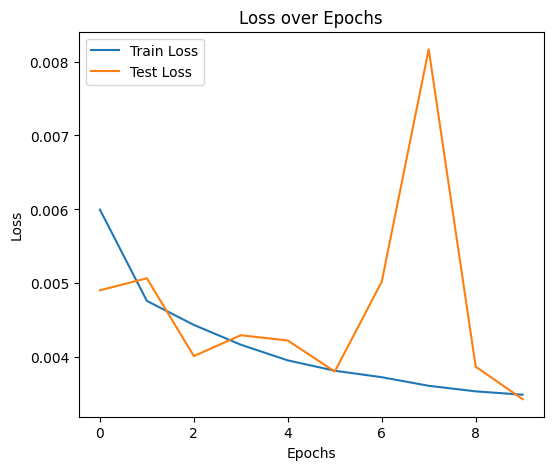

In [80]:
epochs_range = range(EPOCH)
plt.figure(figsize=(6, 5))

plt.plot(epochs_range, train_losses, label='Train Loss')
plt.plot(epochs_range, valid_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.show()

In [81]:
torch.save(best_model.state_dict(), "ssl_unlabeled_mel_resnet_v1.pth")

# Inference

In [82]:
class TestAudioDataset(Dataset):
    def __init__(self, file_paths, fixed_len=64000):
        self.file_paths = file_paths
        self.fixed_len = fixed_len
        self.length = len(file_paths)
        self.resample = T.Resample(32000, SR)

    def __len__(self):
        return self.length

    def __getitem__(self, index):
        wave, _ = torchaudio.load(self.file_paths[index])
        wave = self.resample(wave)

        start_idx = int(0.5 * SR)
        end_idx = int(4.5 * SR)
        wave = wave[:, start_idx:end_idx]
        return wave

In [83]:
test = pd.read_csv("test.csv")
test_dataset = TestAudioDataset(test["path"].values)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [84]:
best_model.eval()
audio_pipeline.eval()
preds = []

for waves in tqdm(test_dataloader):
    specs = audio_pipeline(waves.to(device))
    outputs = best_model(specs)
    pred = F.sigmoid(outputs).detach().cpu().numpy()
    preds += pred.tolist()

100%|██████████| 1563/1563 [08:55<00:00,  2.92it/s]


In [85]:
submit = pd.read_csv("sample_submission.csv")
submit.iloc[:, 1:] = preds
submit.to_csv("ssl_unlabeled_mel_resnet_v1.csv", index=False)

In [86]:
submit.head()

,id,fake,real
0,TEST_00000,0.051757,0.961123
1,TEST_00001,0.032025,0.982475
2,TEST_00002,0.049367,0.962456
3,TEST_00003,0.743466,0.933997
4,TEST_00004,0.167202,0.996528


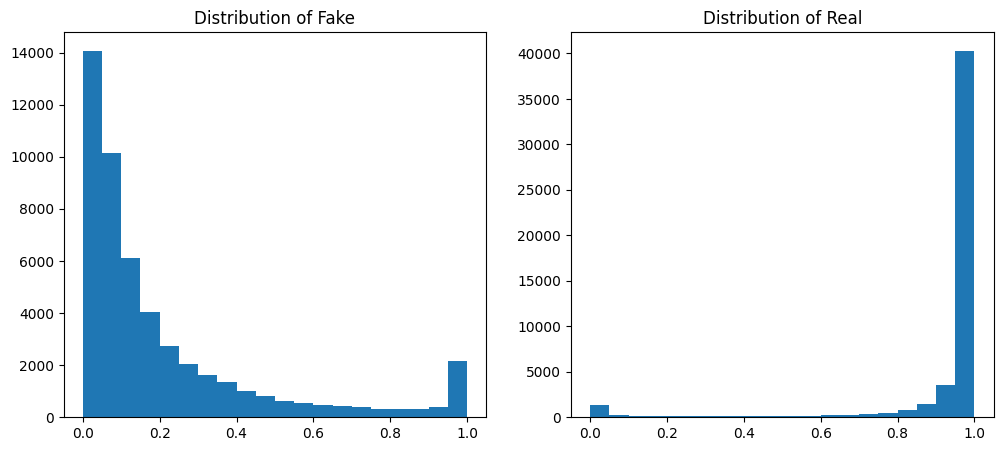

In [87]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.title("Distribution of Fake")
plt.hist(submit["fake"], bins=20)

plt.subplot(1, 2, 2)
plt.title("Distribution of Real")
plt.hist(submit["real"], bins=20)
plt.show()